In [1]:
!pip install shap plotly kaleido scikit-learn pandas numpy matplotlib seaborn -q


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.0/69.0 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 1.7 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import shap
from datetime import datetime, timedelta
import random

In [6]:
def generate_transaction_data(n_samples=3000, anomaly_ratio=0.05):
    """
    Generate realistic synthetic transaction data with built-in anomalies
    """
    np.random.seed(42)
    random.seed(42)

    # Normal transactions
    n_normal = int(n_samples * (1 - anomaly_ratio))
    n_anomalies = n_samples - n_normal

    # Generate base features for normal transactions
    hour_probs = [0.03, 0.03, 0.08, 0.1, 0.12, 0.12, 0.12, 0.12, 0.08, 0.08, 0.06, 0.03, 0.02, 0.01]
    normal_data = {
        'transaction_id': [f'TXN{str(i).zfill(6)}' for i in range(n_normal)],
        'amount': np.random.lognormal(4, 1.5, n_normal),  # Mean ~$100
        'hour': np.random.choice(range(8, 22), n_normal, p=hour_probs),  # Business hours
        'day_of_week': np.random.choice(range(7), n_normal),
        'merchant_category': np.random.choice(['Grocery', 'Restaurant', 'Gas', 'Retail', 'Entertainment'],
                                             n_normal, p=[0.25, 0.25, 0.15, 0.25, 0.1]),
        'transaction_type': np.random.choice(['Debit', 'Credit'], n_normal, p=[0.6, 0.4]),
        'distance_from_home': np.random.gamma(2, 5, n_normal),  # km
        'is_international': np.random.choice([0, 1], n_normal, p=[0.95, 0.05]),
        'days_since_last_transaction': np.random.exponential(1, n_normal),
    }

    # Generate anomalous transactions
    anomaly_data = {
        'transaction_id': [f'TXN{str(i+n_normal).zfill(6)}' for i in range(n_anomalies)],
        'amount': np.concatenate([
            np.random.lognormal(8, 1, n_anomalies//3),  # Very high amounts
            np.random.lognormal(1, 0.5, n_anomalies//3),  # Very low amounts
            np.random.lognormal(4, 2, n_anomalies - 2*(n_anomalies//3))
        ]),
        'hour': np.random.choice(range(24), n_anomalies),  # Any hour including late night
        'day_of_week': np.random.choice(range(7), n_anomalies),
        'merchant_category': np.random.choice(['Grocery', 'Restaurant', 'Gas', 'Retail', 'Entertainment', 'Unknown'],
                                             n_anomalies, p=[0.1, 0.1, 0.1, 0.1, 0.1, 0.5]),
        'transaction_type': np.random.choice(['Debit', 'Credit', 'Wire'], n_anomalies, p=[0.3, 0.3, 0.4]),
        'distance_from_home': np.concatenate([
            np.random.uniform(200, 2000, n_anomalies//2),  # Very far transactions
            np.random.gamma(2, 5, n_anomalies - n_anomalies//2)
        ]),
        'is_international': np.random.choice([0, 1], n_anomalies, p=[0.3, 0.7]),
        'days_since_last_transaction': np.concatenate([
            np.random.uniform(0, 0.01, n_anomalies//2),  # Rapid succession
            np.random.exponential(1, n_anomalies - n_anomalies//2)
        ]),
    }

    # Combine normal and anomalous data
    df_normal = pd.DataFrame(normal_data)
    df_anomaly = pd.DataFrame(anomaly_data)
    df = pd.concat([df_normal, df_anomaly], ignore_index=True)

    # Add derived features
    df['amount_log'] = np.log1p(df['amount'])
    df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)
    df['is_late_night'] = ((df['hour'] < 6) | (df['hour'] > 22)).astype(int)
    df['high_amount'] = (df['amount'] > df['amount'].quantile(0.95)).astype(int)

    # Create timestamp
    start_date = datetime(2024, 1, 1)
    df['timestamp'] = [start_date + timedelta(days=random.randint(0, 365)) for _ in range(len(df))]

    # True labels (for evaluation)
    df['true_anomaly'] = [0]*n_normal + [1]*n_anomalies

    return df

# Generate data
print("🔄 Generating synthetic transaction data...")
df = generate_transaction_data(n_samples=3000, anomaly_ratio=0.05)
print(f"✅ Generated {len(df)} transactions ({df['true_anomaly'].sum()} true anomalies)")
print("\n📊 Dataset Preview:")
print(df.head(10))

🔄 Generating synthetic transaction data...
✅ Generated 3000 transactions (150 true anomalies)

📊 Dataset Preview:
  transaction_id      amount  hour  day_of_week merchant_category  \
0      TXN000000  115.015998    17            0            Retail   
1      TXN000001   44.371774    12            4           Grocery   
2      TXN000002  144.247822    18            2               Gas   
3      TXN000003  536.220139    19            2               Gas   
4      TXN000004   38.427369    14            5        Restaurant   
5      TXN000005   38.428315    11            3        Restaurant   
6      TXN000006  583.368594    13            1        Restaurant   
7      TXN000007  172.630262    16            0           Grocery   
8      TXN000008   26.998692    13            3           Grocery   
9      TXN000009  123.203821    10            3           Grocery   

  transaction_type  distance_from_home  is_international  \
0           Credit           21.259504                 0   
1     

In [7]:
def prepare_features(df):
    """Prepare features for anomaly detection"""
    feature_cols = [
        'amount_log', 'hour', 'day_of_week', 'distance_from_home',
        'is_international', 'days_since_last_transaction', 'is_weekend',
        'is_late_night', 'high_amount'
    ]

    # One-hot encode categorical variables
    df_encoded = pd.get_dummies(df, columns=['merchant_category', 'transaction_type'], prefix=['merchant', 'type'])

    # Get all feature columns
    all_features = feature_cols + [col for col in df_encoded.columns if col.startswith(('merchant_', 'type_'))]

    X = df_encoded[all_features].values

    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    return X_scaled, all_features, scaler, df_encoded

print("\n🔧 Preparing features...")
X_scaled, feature_names, scaler, df_encoded = prepare_features(df)
print(f"✅ Prepared {X_scaled.shape[1]} features")


🔧 Preparing features...
✅ Prepared 18 features


In [8]:
print("\n🤖 Training anomaly detection models...")

# Isolation Forest
iso_forest = IsolationForest(
    contamination=0.05,
    random_state=42,
    n_estimators=100
)
iso_predictions = iso_forest.fit_predict(X_scaled)
iso_scores = iso_forest.score_samples(X_scaled)
df['iso_forest_anomaly'] = (iso_predictions == -1).astype(int)
df['iso_forest_score'] = -iso_scores  # Convert to anomaly score (higher = more anomalous)

# Local Outlier Factor
lof = LocalOutlierFactor(
    contamination=0.05,
    novelty=False,
    n_neighbors=20
)
lof_predictions = lof.fit_predict(X_scaled)
lof_scores = -lof.negative_outlier_factor_
df['lof_anomaly'] = (lof_predictions == -1).astype(int)
df['lof_score'] = lof_scores

# Ensemble: Both models agree
df['ensemble_anomaly'] = ((df['iso_forest_anomaly'] == 1) & (df['lof_anomaly'] == 1)).astype(int)
df['ensemble_score'] = (df['iso_forest_score'] + df['lof_score']) / 2

print("✅ Models trained successfully")


🤖 Training anomaly detection models...
✅ Models trained successfully


In [9]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve

def evaluate_model(y_true, y_pred, scores, model_name):
    """Evaluate anomaly detection model"""
    print(f"\n{'='*60}")
    print(f"{model_name} Performance")
    print(f"{'='*60}")
    print(classification_report(y_true, y_pred, target_names=['Normal', 'Anomaly']))
    print(f"ROC-AUC Score: {roc_auc_score(y_true, scores):.4f}")

    cm = confusion_matrix(y_true, y_pred)
    return cm

# Evaluate models
cm_iso = evaluate_model(df['true_anomaly'], df['iso_forest_anomaly'],
                        df['iso_forest_score'], "Isolation Forest")
cm_lof = evaluate_model(df['true_anomaly'], df['lof_anomaly'],
                       df['lof_score'], "Local Outlier Factor")
cm_ensemble = evaluate_model(df['true_anomaly'], df['ensemble_anomaly'],
                             df['ensemble_score'], "Ensemble")


Isolation Forest Performance
              precision    recall  f1-score   support

      Normal       0.99      0.99      0.99      2850
     Anomaly       0.77      0.77      0.77       150

    accuracy                           0.98      3000
   macro avg       0.88      0.88      0.88      3000
weighted avg       0.98      0.98      0.98      3000

ROC-AUC Score: 0.9729

Local Outlier Factor Performance
              precision    recall  f1-score   support

      Normal       0.96      0.96      0.96      2850
     Anomaly       0.17      0.17      0.17       150

    accuracy                           0.92      3000
   macro avg       0.56      0.56      0.56      3000
weighted avg       0.92      0.92      0.92      3000

ROC-AUC Score: 0.6750

Ensemble Performance
              precision    recall  f1-score   support

      Normal       0.95      1.00      0.97      2850
     Anomaly       0.52      0.07      0.13       150

    accuracy                           0.95      300

In [10]:
explainer = shap.TreeExplainer(iso_forest)
shap_values = explainer.shap_values(X_scaled)

In [11]:
def generate_explainability_card(transaction_idx, df, df_encoded, shap_values, feature_names, top_n=5):
    """
    Generate a detailed explainability card for a specific transaction
    """
    row = df.iloc[transaction_idx]
    shap_row = shap_values[transaction_idx]

    # Get top contributing features
    feature_importance = list(zip(feature_names, shap_row))
    feature_importance.sort(key=lambda x: abs(x[1]), reverse=True)
    top_features = feature_importance[:top_n]

    card = {
        'transaction_id': row['transaction_id'],
        'timestamp': row['timestamp'],
        'amount': row['amount'],
        'is_anomaly': row['ensemble_anomaly'],
        'anomaly_score': row['ensemble_score'],
        'iso_forest_score': row['iso_forest_score'],
        'lof_score': row['lof_score'],
        'top_suspicious_factors': []
    }

    # Generate human-readable explanations
    for feat, shap_val in top_features:
        explanation = {
            'feature': feat,
            'shap_value': shap_val,
            'contribution': 'Increases' if shap_val > 0 else 'Decreases',
        }

        # Add context-specific explanations
        if 'amount' in feat:
            explanation['reason'] = f"Transaction amount ${row['amount']:.2f} is {'unusually high' if row['amount'] > df['amount'].quantile(0.95) else 'unusual'}"
        elif 'hour' in feat:
            explanation['reason'] = f"Transaction at {int(row['hour'])}:00 is {'outside normal business hours' if row['is_late_night'] else 'at an unusual time'}"
        elif 'distance' in feat:
            explanation['reason'] = f"Transaction {row['distance_from_home']:.1f}km from home is {'very far' if row['distance_from_home'] > 100 else 'unusual'}"
        elif 'international' in feat:
            explanation['reason'] = "International transaction" if row['is_international'] else "Domestic transaction"
        elif 'days_since' in feat:
            explanation['reason'] = f"Only {row['days_since_last_transaction']:.2f} days since last transaction" if row['days_since_last_transaction'] < 0.1 else "Normal transaction frequency"
        else:
            explanation['reason'] = f"{feat} has unusual pattern"

        card['top_suspicious_factors'].append(explanation)

    return card

# Generate cards for top anomalies
top_anomalies_idx = df.nlargest(10, 'ensemble_score').index
explainability_cards = []


print("EXPLAINABILITY CARDS - TOP 10 SUSPICIOUS TRANSACTIONS")


for idx in top_anomalies_idx:
    card = generate_explainability_card(idx, df, df_encoded, shap_values, feature_names)
    explainability_cards.append(card)

    print(f"\n{'─'*80}")
    print(f"Transaction ID: {card['transaction_id']}")
    print(f"   Timestamp: {card['timestamp']}")
    print(f"   Amount: ${card['amount']:.2f}")
    print(f"   Anomaly Score: {card['anomaly_score']:.4f} (Isolation: {card['iso_forest_score']:.4f}, LOF: {card['lof_score']:.4f})")
    print(f"   Status: {'ANOMALOUS' if card['is_anomaly'] else 'Normal'}")
    print(f"\n   Top Suspicious Factors:")
    for i, factor in enumerate(card['top_suspicious_factors'], 1):
        print(f"   {i}. {factor['feature']}: {factor['reason']}")
        print(f"      → SHAP Impact: {factor['shap_value']:.4f} ({factor['contribution']} suspicion)")


🎴 EXPLAINABILITY CARDS - TOP 10 SUSPICIOUS TRANSACTIONS

────────────────────────────────────────────────────────────────────────────────
🚨 Transaction ID: TXN002972
   Timestamp: 2024-07-08 00:00:00
   Amount: $206.08
   Anomaly Score: 1.7409 (Isolation: 0.5499, LOF: 2.9319)
   Status: ✅ Normal

   Top Suspicious Factors:
   1. type_Wire: type_Wire has unusual pattern
      → SHAP Impact: -1.6142 (Decreases suspicion)
   2. merchant_Retail: merchant_Retail has unusual pattern
      → SHAP Impact: -0.6306 (Decreases suspicion)
   3. is_weekend: is_weekend has unusual pattern
      → SHAP Impact: -0.6038 (Decreases suspicion)
   4. type_Debit: type_Debit has unusual pattern
      → SHAP Impact: -0.4722 (Decreases suspicion)
   5. day_of_week: day_of_week has unusual pattern
      → SHAP Impact: -0.2540 (Decreases suspicion)

────────────────────────────────────────────────────────────────────────────────
🚨 Transaction ID: TXN002999
   Timestamp: 2024-09-07 00:00:00
   Amount: $2.74
   

In [12]:
fig1 = make_subplots(
    rows=1, cols=2,
    subplot_titles=('Isolation Forest Scores', 'LOF Scores')
)

fig1.add_trace(
    go.Histogram(x=df[df['true_anomaly']==0]['iso_forest_score'], name='Normal',
                 marker_color='lightblue', opacity=0.7),
    row=1, col=1
)
fig1.add_trace(
    go.Histogram(x=df[df['true_anomaly']==1]['iso_forest_score'], name='Anomaly',
                 marker_color='red', opacity=0.7),
    row=1, col=1
)
fig1.add_trace(
    go.Histogram(x=df[df['true_anomaly']==0]['lof_score'], name='Normal',
                 marker_color='lightblue', opacity=0.7, showlegend=False),
    row=1, col=2
)
fig1.add_trace(
    go.Histogram(x=df[df['true_anomaly']==1]['lof_score'], name='Anomaly',
                 marker_color='red', opacity=0.7, showlegend=False),
    row=1, col=2
)

fig1.update_layout(height=400, title_text="Anomaly Score Distributions", showlegend=True)
fig1.show()

In [13]:
fig2 = make_subplots(
    rows=1, cols=3,
    subplot_titles=('Isolation Forest', 'Local Outlier Factor', 'Ensemble'),
    specs=[[{'type': 'heatmap'}, {'type': 'heatmap'}, {'type': 'heatmap'}]]
)

for i, (cm, title) in enumerate([(cm_iso, 'IF'), (cm_lof, 'LOF'), (cm_ensemble, 'Ensemble')], 1):
    fig2.add_trace(
        go.Heatmap(z=cm, x=['Normal', 'Anomaly'], y=['Normal', 'Anomaly'],
                   colorscale='RdYlGn_r', text=cm, texttemplate='%{text}',
                   showscale=(i==3)),
        row=1, col=i
    )

fig2.update_layout(height=400, title_text="Confusion Matrices")
fig2.show()

In [14]:
shap_importance = np.abs(shap_values).mean(axis=0)
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': shap_importance
}).sort_values('importance', ascending=True).tail(15)

fig3 = go.Figure(go.Bar(
    x=feature_importance_df['importance'],
    y=feature_importance_df['feature'],
    orientation='h',
    marker_color='steelblue'
))
fig3.update_layout(
    title="Top 15 Most Important Features (SHAP)",
    xaxis_title="Mean |SHAP value|",
    yaxis_title="Feature",
    height=500
)
fig3.show()

In [15]:
fig4 = go.Figure()

normal_trans = df[df['ensemble_anomaly'] == 0]
anomaly_trans = df[df['ensemble_anomaly'] == 1]

fig4.add_trace(go.Scatter(
    x=normal_trans['timestamp'],
    y=normal_trans['amount'],
    mode='markers',
    name='Normal',
    marker=dict(size=5, color='lightblue', opacity=0.6)
))

fig4.add_trace(go.Scatter(
    x=anomaly_trans['timestamp'],
    y=anomaly_trans['amount'],
    mode='markers',
    name='Anomaly',
    marker=dict(size=10, color='red', symbol='star', line=dict(width=1, color='darkred'))
))

fig4.update_layout(
    title="Transaction Timeline with Anomalies",
    xaxis_title="Date",
    yaxis_title="Transaction Amount ($)",
    yaxis_type="log",
    height=500
)
fig4.show()


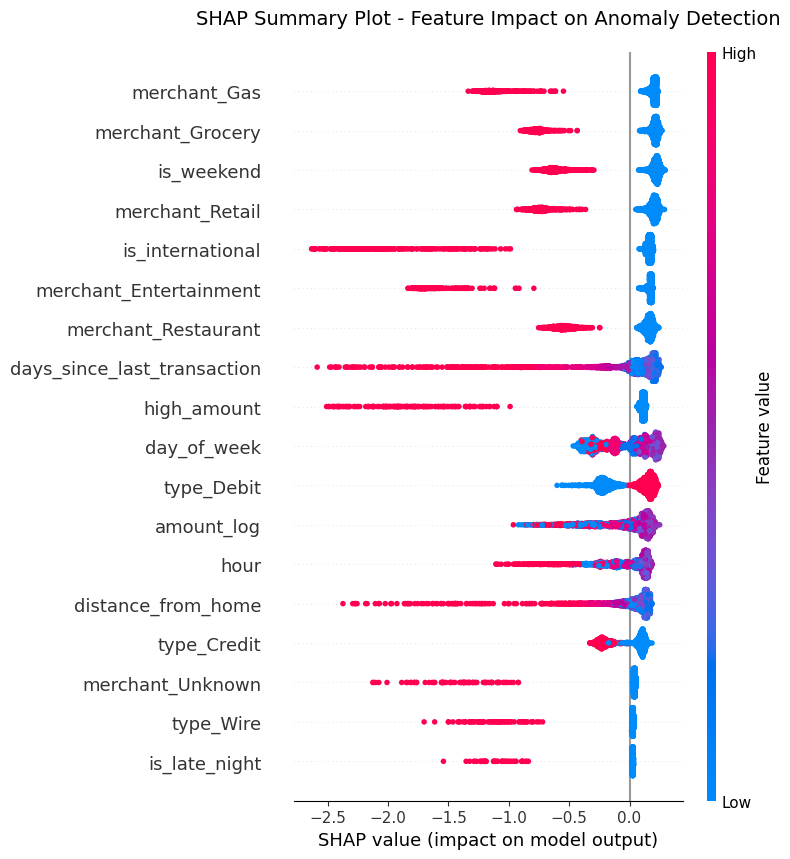

In [17]:
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_scaled, feature_names=feature_names, show=False)
plt.title("SHAP Summary Plot - Feature Impact on Anomaly Detection", fontsize=14, pad=20)
plt.tight_layout()
plt.show()

In [18]:
# 6. ROC Curves
from sklearn.metrics import roc_curve, auc

fig6 = go.Figure()

for model_name, scores in [('Isolation Forest', df['iso_forest_score']),
                           ('LOF', df['lof_score']),
                           ('Ensemble', df['ensemble_score'])]:
    fpr, tpr, _ = roc_curve(df['true_anomaly'], scores)
    roc_auc = auc(fpr, tpr)
    fig6.add_trace(go.Scatter(
        x=fpr, y=tpr,
        name=f'{model_name} (AUC = {roc_auc:.3f})',
        mode='lines'
    ))

fig6.add_trace(go.Scatter(
    x=[0, 1], y=[0, 1],
    name='Random',
    mode='lines',
    line=dict(dash='dash', color='gray')
))

fig6.update_layout(
    title="ROC Curves - Model Comparison",
    xaxis_title="False Positive Rate",
    yaxis_title="True Positive Rate",
    height=500
)
fig6.show()

In [20]:
print(f"Total Transactions: {len(df)}")
print(f"True Anomalies: {df['true_anomaly'].sum()}")
print(f"Detected Anomalies (Ensemble): {df['ensemble_anomaly'].sum()}")
print(f"Precision: {cm_ensemble[1,1] / (cm_ensemble[1,1] + cm_ensemble[0,1]):.2%}")
print(f"Recall: {cm_ensemble[1,1] / (cm_ensemble[1,1] + cm_ensemble[1,0]):.2%}")
print(f"F1-Score: {2 * (cm_ensemble[1,1] / (cm_ensemble[1,1] + cm_ensemble[0,1])) * (cm_ensemble[1,1] / (cm_ensemble[1,1] + cm_ensemble[1,0])) / ((cm_ensemble[1,1] / (cm_ensemble[1,1] + cm_ensemble[0,1])) + (cm_ensemble[1,1] / (cm_ensemble[1,1] + cm_ensemble[1,0]))):.2%}")

Total Transactions: 3000
True Anomalies: 150
Detected Anomalies (Ensemble): 21
Precision: 52.38%
Recall: 7.33%
F1-Score: 12.87%
